In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import zarr
import os
import tqdm
# from tqdm.auto import trange
from tqdm.notebook import trange

from rad_utils import remove_all_ticks_and_labels

# (KS) Kolmogorov-Smirnov test
- answers the question, "How likely is it that we would see a collection of samples like this if they were drawn from that probability distribution?"
- you have a 1D null/reference distribution and samples from your empirical distribution
- it quantifies a distance between the empirical distribution function of the sample and the cumulative distribution function of the reference distribution

To get some intuition, let's try generating random samples from a normal distribution, and compare this against a reference normal distribution. 

ks_statistic: 0.0840519296105755
p_value, normal dist: 0.11187896875462511
ks_statistic: 0.11007924271578184
p_value, uniform dist: 0.0144773865268207


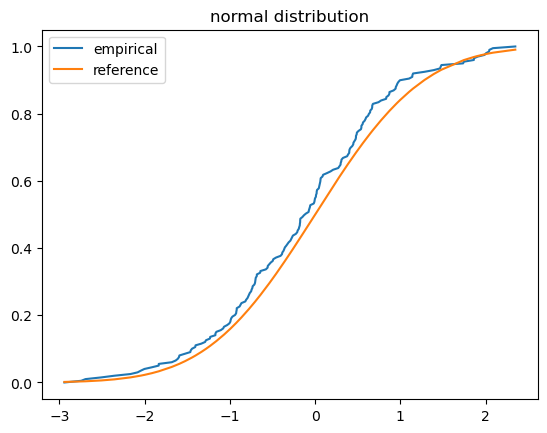

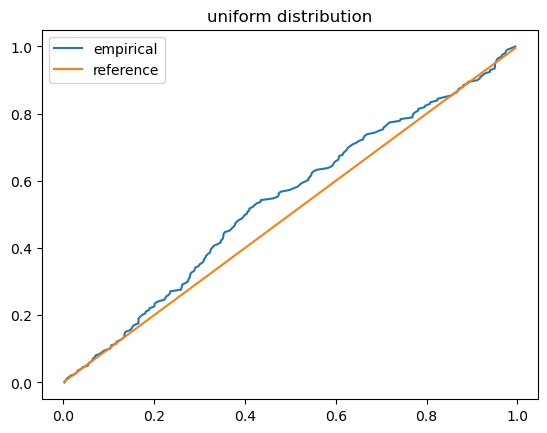

In [63]:
import scipy.stats as stats

# generate a random sample from normal distribution
r=stats.norm.rvs(size=200)

# sort the data:
data_sorted = np.sort(r)

# calculate the proportional values of samples
p = 1. * np.arange(len(r)) / (len(r) - 1)

fig, ax = plt.subplots(1, 1)
ax.plot(data_sorted, p, label='empirical')

# plot reference cdf of a normal distribution
c = stats.norm.cdf(data_sorted, 0, 1)
ax.plot(data_sorted, c, label='reference')
ax.legend()
ax.set(title='normal distribution')

ks_statistic, p_value = stats.kstest(r, stats.norm.cdf)

print('ks_statistic:', ks_statistic)
print('p_value, normal dist:', p_value)



# for a uniform dist
fig, ax = plt.subplots(1, 1)
r = stats.uniform.rvs(size=200)
data_sorted = np.sort(r)
ax.plot(data_sorted, p, label='empirical')
c = stats.uniform.cdf(data_sorted)
ax.plot(data_sorted, c, label='reference')
ax.legend()
ax.set(title='uniform distribution')
ks_statistic, p_value = stats.kstest(r, stats.uniform.cdf)

print('ks_statistic:', ks_statistic)
print('p_value, uniform dist:', p_value)

If the p-value is higher than our threshold of 0.05, we accept the null hypothesis instead of the default "two-sided" alternative, i.e. the data *are* distributed according to the uniform distribution.

# using real data

Now we can compare our data drawn from the sequential sampling process against a uniform distribution (which our model was trained on). However, because our samples contain a small amount of noise that pushes it away from the manifold, we must first project our data onto the ground truth manifold.

Our 2D swiss roll manifold can be parameterized by a single variable $t$, from which the ground truth manifold is uniformly sampled. The sequentially sampled data points are therefore projected onto the ground truth manifold, from which we acquire the index corresponding to the latent 1D variable $t$. The KS test is performed on the distribution of this variable.

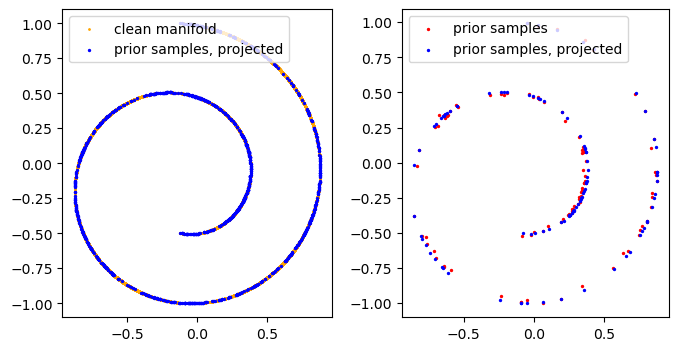

In [77]:
# prior sampled manifold
number_of_samples = int(1000)

# load sequentially sampled prior data 
prior_samples = zarr.load('saved_arrays/kl_divergence/prior_samples_1e5.zarr')
prior_samples = prior_samples[:number_of_samples, :]

# clean ground truth manifold samples
from rad_utils import generate_2d_swiss_roll
clean_manifold_num_samples = int(5e4)  # supersampled manifold
clean_manifold_t, clean_manifold, min, max = generate_2d_swiss_roll(clean_manifold_num_samples, rescaled=True)

# project onto clean manifold
from rad_utils import project_onto_clean_2d_roll_manifold
rad_points_xy, rad_points_t = project_onto_clean_2d_roll_manifold(prior_samples, clean_manifold, min, max, clean_manifold_t)

# plot
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].scatter(*clean_manifold.T, s=1, c='orange', label='clean manifold')
ax[0].scatter(*rad_points_xy.T, s=2, c='blue', label='prior samples, projected')
ax[0].legend(loc='upper left')
ax[0].set_aspect('equal')

ax[1].scatter(*prior_samples[:100].T, s=2, c='red', label='prior samples')
ax[1].scatter(*rad_points_xy[:100].T, s=2, c='blue', label='prior samples, projected')
ax[1].legend(loc='upper left')
ax[1].set_aspect('equal')


ks statistic: 0.03604182083641672
p_value, uniform dist: 0.14522567167484324


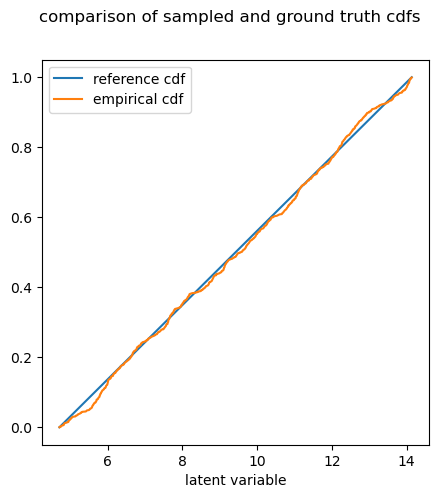

In [78]:
# ---------------- comparison of empirical and reference cdfs ---------------- #
fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharey=True)
fig.suptitle('comparison of sampled and ground truth cdfs')

# reference cdf
reference_dist_cdf = stats.uniform.cdf(clean_manifold_t, loc=1.5 * np.pi, scale=3 * np.pi)

# plotting the empirical cdf against the reference cdf
# reference cdf (uniform distribution)
ax.plot(clean_manifold_t, reference_dist_cdf, label='reference cdf')


# empirical cdf for rad
empirical_samples_rad = rad_points_t[:, 0]
x_rad = np.sort(empirical_samples_rad)
y_rad = np.arange(len(x_rad))/float(len(x_rad))
ax.plot(x_rad, y_rad, label='empirical cdf')
ax.set(xlabel='latent variable')
ax.legend()

# ---------------------------------- KS test --------------------------------- #
# two sided ks test between rad and vanilla models
statistic, p_value = stats.kstest(empirical_samples_rad, 'uniform', args=(1.5 * np.pi, 3 * np.pi))
# statistic, p_value = stats.kstest(empirical_samples_rad, stats.uniform.cdf, args=(1.5 * np.pi, 3 * np.pi))
print('ks statistic:', statistic)
print('p_value, uniform dist:', p_value)

We see that the p value is greater than 0.05, meaning that we can accept our hypothesis that the data comes from a uniform distribution. 

# how does the p value change as a function of sample size?

[Text(0, 0.5, 'p-value'),
 Text(0.5, 0, 'number of samples'),
 Text(0.5, 1.0, 'KS test p-value dependence on sample size')]

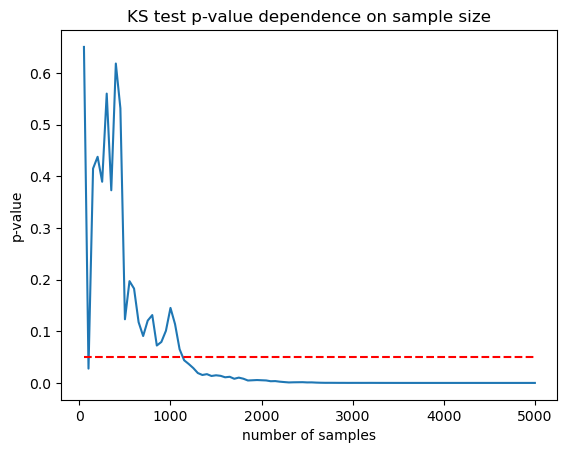

In [107]:
# prior sampled manifold
number_of_samples = int(5000)

# load sequentially sampled prior data 
prior_samples = zarr.load('saved_arrays/kl_divergence/prior_samples_1e5.zarr')
prior_samples = prior_samples[:number_of_samples, :]

# clean ground truth manifold samples
from rad_utils import generate_2d_swiss_roll
clean_manifold_num_samples = int(5e4)  # supersampled manifold
clean_manifold_t, clean_manifold, min, max = generate_2d_swiss_roll(clean_manifold_num_samples, rescaled=True)

# project onto clean manifold
from rad_utils import project_onto_clean_2d_roll_manifold
rad_points_xy, rad_points_t = project_onto_clean_2d_roll_manifold(prior_samples, clean_manifold, min, max, clean_manifold_t)


# empirical_samples_rad = rad_points_t[:, 0]


# ---------------------------------- KS test --------------------------------- #
p_values = []
statistics = []
for i in np.arange(50, 5000+50, 50):
    statistic, p_value = stats.kstest(rad_points_t[:i, 0], stats.uniform.cdf, args=(1.5 * np.pi, 3 * np.pi))
    p_values.append(p_value)
    statistics.append(statistic)

fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(50, 5000+50, 50), p_values)
ax.plot(np.arange(50, 5000+50, 50), np.ones(len(p_values)) * 0.05, 'r--')
ax.set(ylabel='p-value', xlabel='number of samples', title='KS test p-value dependence on sample size')


# ax[1].plot(np.arange(100, 5100, 50), statistics)